In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance
from scipy.stats import mode
from pyproj import Proj,transform
import seaborn as sns
import copy

# Average Farm Sizes (no. sheep and no. cow)

In [2]:
Data=pd.read_csv("All_data",sep = '\t', header = 0)

In [3]:
# cattle = round(np.mean(Data['cattle'].values))
# sheep = round(np.mean(Data['sr'].values))
cattle = 700
sheep = 300
NumLivestock = cattle+sheep
NumLivestock = int(NumLivestock)

In [4]:
psi = 0.00657
# psi = 2.5
nu = 1.99*(10**(-4.8))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863
N =1
# epsilon = np.zeros(N)
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods (5 days)
r = np.random.negative_binomial(30, 30/38, N) #Draw infectious periods (8 days)
q = np.random.negative_binomial(2*28, 2*28/(4*28), N) #Draw immune periods (2 months)
v = np.random.negative_binomial(6*28, 6*28/(12*28))
tr = 2*np.ones(1)


In [5]:
Data

,Unnamed: 0,Easting,Northing,cattle,contact_animal,contact_people,equipment,fmd,grazing,lat,...,milk,ruminant,sr,study,vaccine,vet,water,water_grazing,xcoord,ycoord
0,0,4954407.0,-5569944.0,2,0,0,1,0,0,-0.301046,...,1,NaN,1.0,ntc16,1,1,0,0.0,756.0,30701.0
1,1,4954385.0,-5569870.0,2,0,0,0,0,0,-0.300520,...,1,NaN,0.0,ntc16,0,0,0,0.0,734.0,30775.0
2,2,4954266.0,-5569350.0,0,0,1,1,0,0,-0.296813,...,0,NaN,3.0,ntc16,1,0,0,0.0,615.0,31295.0
3,3,4954350.0,-5569305.0,6,0,0,0,1,0,-0.296488,...,0,NaN,8.0,ntc16,0,0,0,0.0,699.0,31340.0
4,4,4954328.0,-5569934.0,6,0,0,0,1,0,-0.300976,...,1,NaN,9.0,ntc16,0,0,0,0.0,677.0,30711.0
5,5,4954060.0,-5569396.0,2,0,0,1,1,1,-0.297146,...,1,NaN,6.0,ntc16,0,0,0,1.0,409.0,31249.0
6,6,4954484.0,-5570078.0,2,0,0,1,0,0,-0.302001,...,0,NaN,0.0,ntc16,1,1,0,0.0,833.0,30567.0
7,7,4954078.0,-5569460.0,0,0,0,0,0,0,-0.297607,...,0,NaN,3.0,ntc16,0,0,0,0.0,427.0,31185.0
8,8,4954830.0,-5569435.0,7,0,0,1,0,0,-0.297407,...,1,NaN,6.0,ntc16,0,0,0,0.0,1179.0,31210.0
9,9,4954520.0,-5568875.0,3,0,0,1,0,0,-0.293415,...,1,NaN,10.0,ntc16,0,1,0,0.0,869.0,31770.0


In [28]:
t = 0
A = np.zeros(shape = (1, 10))
A[:,0] = -1 
I = 0
vac = 0

#initially one infected
initial = 0
I += 1
A[initial, ] = [initial, 0, s[initial], r[initial], tr[initial], q[initial], 0, 0, 0, 0]

infect_cow = 1
infect_sheep = 0
tmax = 100
λ = 0.1
μ = 0.98
InfectedTime = np.zeros(tmax)

while t < tmax:
    t = t+1
#     print(t)
    infNum = 0

    ################################### WITHIN FARM INFECTION ####################################
    Num_livestock = infect_cow + infect_sheep
    inf = 1-((1-λ)**Num_livestock)
    for animals in range(NumLivestock):

        p_beta = np.random.uniform(0,1)

        if (p_beta<inf) and (infect_sheep+infect_cow)<=NumLivestock:
            if (random.random() < 0.5 and sheep>=1 and infect_sheep<sheep):
#                 print('infect sheep')
                infect_sheep += 1
            elif (cattle>=1 and infect_cow<cattle):
#                 print('infect cow')
                infect_cow +=1


    #### WITHIN FARM RECOVERY ####
    infected = infect_cow+infect_sheep
    InfectedTime[t] = infected
    
    for animals in range(int(infect_cow+infect_sheep)):
        recover = np.random.uniform(0,1)

        if recover < μ and (infect_sheep+infect_cow) >=1 :
            if (random.random() <(infect_sheep/(infect_sheep+infect_cow)) and infect_sheep>=1 ):
#                 print('recover sheep')
                infect_sheep -= 1
            elif infect_cow>=1: 
#                 print('recover cow', infect_cow)
                infect_cow -=1
            if infect_sheep+infect_cow ==0: 
                I = 4
                infect_sheep= 0
                infect_cow= 0
                A[0, 6] = A[0, 5] +t
    ################################### end of each day #########################################

    if I == 4:
        InfectedTime[t+1] = 0
        break
    if t == (tmax-1):
        InfectedTime[t] = infect_cow + infect_sheep
        break


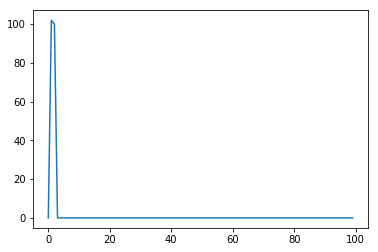

In [29]:
plt.plot(range(tmax), InfectedTime)
# plt.xlim([0,15])